In [38]:
#  데이터 처리 모듈
import pandas as pd
from sklearn.impute import KNNImputer
# 행렬 등 통계 연산 모듈
import numpy as np
from scipy.stats import iqr
from scipy.interpolate import interp1d
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
# 지수형 표기법 e를 연속형 변환
pd.options.display.float_format = '{:.4f}'.format
# 타입 어노테이션(Any, Sequence 등의 메서드 활용)
from typing import *
import os

# 구글 드라이브 마운트
from google.colab import drive
drive.mount("/content/drive")
import os

# 조합 찾는 반복문 메서드
from itertools import permutations
from itertools import combinations

# 데이터 시각화
import matplotlib.pyplot as plt
# from matplotlib.pyplot import
import matplotlib.font_manager as fm
import missingno as msno
import seaborn as sns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install impyute

In [ ]:
from impyute.imputation.cs import fast_knn

In [ ]:
# apt-get : 패키지 설치 명령어
# -qq : 에러외의 메세지 숨기는 옵션키
!apt-get -qq install fonts-nanum

fe = fm.FontEntry(
    fname=r"/usr/share/fonts/truetype/nanum/NanumGothic.ttf",
    # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')
# 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)
# Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'})
# 폰트 설정

Selecting previously unselected package fonts-nanum.
(Reading database ... 120895 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [ ]:
class LoadGoogleDriveData():
  def __init__(self, data = None):
    self.data = data

  def loadData(self, file_path: str, file_name_extension,
               columnTF: bool, unicode: str) -> pd.DataFrame():
    self.data = pd.read_csv(os.path.join(file_path + file_name_extension),
                            index_col = columnTF,
                            sep = ",",
                            na_values = "NaN",
                            encoding = unicode)
    return self.data

  def loadTxTData(self, file_path: str, file_name_extension,
               columnTF: bool, unicode: str) -> pd.DataFrame():
    self.data = pd.read_csv(os.path.join(file_path + file_name_extension),
                            index_col = columnTF,
                            sep = "|",
                            na_values = "NaN",
                            encoding = unicode)
    return self.data

  def loadExcelData(self, file_path: str, file_name_extension,
               columnTF: bool) -> pd.DataFrame():
    self.data = pd.read_excel(os.path.join(file_path + file_name_extension),
                              index_col = columnTF)
    return self.data

  # 용량이 큰 csv 파일 읽어오기(fopen - fread와 유사한 방식)
  def loadDataWithChunking(self, file_path: str, file_name_extension,
                           chunking_row_num: int, columnTF: bool, unicode: str) -> pd.DataFrame():
    chunkdata = pd.read_csv(os.path.join(file_path + file_name_extension),
                            chunksize = chunking_row_num,
                            index_col = columnTF,
                            sep = ",",
                            na_values = "NaN",
                            encoding = unicode)
    self.data = list(chunkdata)
    self.data = pd.concat(self.data)

    return self.data

In [ ]:
mountInstance = LoadGoogleDriveData()

### 1.오아시스 비즈니스(필지고유번호 & 법정동읍면동코드 & 외식업종)  데이터

In [ ]:
CONTEST_2022 = mountInstance.loadDataWithChunking(
    file_path = "/content/drive/MyDrive/2023BigContest/data/contest data/", file_name_extension = "필지단위 소상공인 매출등급 정보.csv",
    unicode = "cp949", chunking_row_num = 10**5, columnTF = False)

In [ ]:
CONTEST_2023 = mountInstance.loadExcelData(
    file_path = "/content/drive/MyDrive/2023BigContest/data/contest data/", file_name_extension = "소상공인 매출등급 예상 대상 필지.xlsx",
    columnTF = False)

```
CONTEST_2023 = mountInstance.loadDataWithChunking(
    file_path = "/content/drive/MyDrive/2023BigContest/data/contest data/", file_name_extension = "소상공인 매출등급 예상 대상 필지.csv",
    unicode = "cp949", chunking_row_num = 10**5, columnTF = False)
```

### 2.KCD(상권코드 & 외식업종 중분류) 소상공인 신용데이터

In [ ]:
KCD_2022_2023 = mountInstance.loadData(
    file_path = "/content/drive/MyDrive/2023BigContest/data/DESILO_PLATFORM_DATA/", file_name_extension = "SOHO_MERGE_DATA_LIST.csv",
    unicode = "utf-8", columnTF = False)

### 3.행정동코드 - 상권코드 매핑 데이터
```
KCD_MERGE_LIST[0] = KCD_MERGE_LIST[0].drop(["상권_코드_2022"], axis = 1)
KCD_MERGE_LIST[0].drop_duplicates(subset = ["STDG_EMD_CD"], inplace = True)
KCD_MERGE_LIST[0].isnull().sum()
  # 상권코드           431
  # 매출액_변동계수       431
KCD_MERGE_LIST[0].isnull().sum()
  # 상권코드               404
len(MARKET_LOC_MAP["상권_코드_2022"].unique())
  # 1622
len(MARKET_LOC_MAP['STDG_EMD_CD'].unique())
  # 465
```

In [ ]:
MARKET_LOC_MAP = mountInstance.loadData(
    file_path = "/content/drive/MyDrive/2023BigContest/data/",
    file_name_extension = "market_loc_map.csv",
    unicode = "euc-kr", columnTF = False)

In [ ]:
MARKET_LOC_MAP

,상권_코드_2022,상권_코드_2023,행정동_코드,법정동_코드,STDG_EMD_CD
0,2110008,3110008,11110515,11110101,11110101
1,2110008,3110008,11110515,11110102,11110102
2,2110008,3110008,11110515,11110103,11110103
3,2110008,3110008,11110515,11110104,11110104
4,2110008,3110008,11110515,11110105,11110105
...,...,...,...,...,...
3453,2130102,3130102,11230750,11230110,11230110
3454,2130166,3130166,11380590,11380107,11380107
3455,2130113,3130113,11260690,11260106,11260106
3456,2130124,3130124,11290780,11290138,11290138


### 4.서울열린데이터광장 상권특성 공공데이터

### 5.분기별 상권특성 공공데이터 전처리

### 6.분기별 상권별 상권특성 공공데이터 병합

### 7.소호 신용데이터(KCD) 이상치 처리 및 결측값 대체

* KCD_NUM_LIST : 연속형 변수만 추출하여 이상치를 결측값으로 처리한 데이터의 리스트(IQR)
* KCD_IMPUTED_DATA : 유사도가 높은 컬럼별 결측값을 최근접 이웃 5개 데이터의 평균값으로 대체한 데이터의 리스트(KNN, K = 5)
* KCD_PREPROCESS_DATA : 전처리 완료된 데이터에 상권코드, 상권명, 기준일자 등 인덱스 포함한 데이터의 리스트

In [ ]:
KCD_DATA = mountInstance.loadData(
    file_path = "/content/drive/MyDrive/2023BigContest/data/DESILO_PLATFORM_DATA/", file_name_extension = "KCD_DATA.csv",
    unicode = "euc-kr", columnTF = False)

In [ ]:
KCD_DATA

,기준일자,상권_식별자,상권코드,배달매출액_변동계수,주말배달매출액_변동계수,손익분기점매출액_변동계수,사업장방문고객수_평균,정규고용인원_평균,주말카드매출액_변동계수,매입액_변동계수,...,경영위기사업장_총합,사업장방문신규고객수_평균,월임대료_변동계수,임대보증금_변동계수,매출액_변동계수,카드매출액_변동계수,사업장방문고객수_변동계수,사업장방문신규고객수_변동계수,상권명,외식업종_중분류
0,202201,DMC(디지털미디어시티)_카페,2120098,2.1558,2.5660,0.5387,6.3708,0.8292,1.3211,0.7483,...,0.0000,6.6692,0.5341,0.5648,0.4986,0.4845,0.7065,0.4988,DMC(디지털미디어시티),카페
1,202201,가락시장역_한식,2120234,1.8341,1.9303,0.4745,4.9360,2.3500,1.4125,0.5770,...,0.0000,3.3360,0.5646,0.5735,1.0273,1.1870,1.0395,1.0085,가락시장역,한식
2,202201,가로수길_술집,2120186,2.4496,2.4495,0.7954,3.3886,1.0431,1.6146,0.8874,...,0.0000,2.9971,1.0291,1.1673,0.8737,0.9827,1.1755,0.9964,가로수길,술집
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2689,202303,"신촌역(신촌역, 신촌로터리)_카페",3120094,2.1606,2.2517,0.5606,7.7299,1.2906,0.9155,0.7616,...,0.0000,5.3143,0.5803,0.6383,0.7098,0.7216,0.7822,0.7560,"신촌역(신촌역, 신촌로터리)",카페
2690,202303,"총신대입구역(이수, 총신대)_카페",3120156,2.1606,2.2517,0.5606,7.7299,1.2906,0.9155,0.7616,...,2.0000,5.3143,0.5803,0.6383,0.7098,0.7216,0.7822,0.7560,"총신대입구역(이수, 총신대)",카페
2691,202303,홍대 걷고싶은 거리_술집,3130191,2.1606,2.2517,0.5606,7.7299,1.2906,0.9155,0.7616,...,2.0000,5.3143,0.5803,0.6383,0.7098,0.7216,0.7822,0.7560,홍대 걷고싶은 거리,술집


### 8.분기별 상권데이터와 월별 소호 신용데이터를 오아시스비즈니스 행정동코드에 맞추어 분기별로 변환

In [ ]:
MARKET_2022_GROUPED = mountInstance.loadData(
    file_path = "/content/drive/MyDrive/2023BigContest/data/DESILO_PLATFORM_DATA/", file_name_extension = "MARKET_2022_JOIN_GROUPED.csv",
    unicode = "utf-8", columnTF = False)

In [ ]:
# MARKET_2022_GROUPED.drop("2022년도_상권_코드", axis = 1, inplace = True)
MARKET_2022_GROUPED[['기준_년_코드', '기준_분기_코드']] = MARKET_2022_GROUPED[['기준_년_코드', '기준_분기_코드']].astype("str")
MARKET_2022_GROUPED["기준일자"] = MARKET_2022_GROUPED['기준_년_코드'] + MARKET_2022_GROUPED['기준_분기_코드'] + "Q"
# MARKET_2022_GROUPED['월'] = MARKET_2022_GROUPED['기준_분기_코드'].apply(lambda x: '1 2 3' if x == 1 else ('4 5 6' if x == 2 else ('7 8 9' if x == 3 else ('10 11 12' if x == 4 else x))))

In [ ]:
MARKET_2023_GROUPED = mountInstance.loadData(
    file_path = "/content/drive/MyDrive/2023BigContest/data/DESILO_PLATFORM_DATA/", file_name_extension = "MARKET_2023_JOIN_GROUPED.csv",
    unicode = "utf-8", columnTF = False)

In [ ]:
MARKET_2023_GROUPED[['기준_년_코드', '기준_분기_코드']] = MARKET_2023_GROUPED[['기준_년_코드', '기준_분기_코드']].astype("str")
MARKET_2023_GROUPED["기준일자"] = MARKET_2023_GROUPED['기준_년_코드'] + MARKET_2023_GROUPED['기준_분기_코드'] + "Q"
# MARKET_2023_GROUPED['월'] = MARKET_2023_GROUPED['기준_분기_코드'].apply(lambda x:'1 2 3' if x == 1 else x)

In [ ]:
class QuartertoMonth():
  def __init__(self, KCD_dataframe, MARKET_2022, MARKET_2023, KCD_COLUMNS = None):
    self.KCD_dataframe = KCD_dataframe
    self.KCD_COLUMNS = KCD_COLUMNS
    self.MARKET_2022 = MARKET_2022
    self.MARKET_2023 = MARKET_2023

    self.dataframe_month_list = []
    self.dataframe_quarter_list = []
    self.dataframe_market_list = []

  def splitKCDQuarterData(self, base_date: str, date_time1, date_time2,
                       remove_columns: List, groupby_standard_columns: List):
    # 월별 소호 신용데이터를 분기별로 만들기 위한 집계 연산(GROUP BY)을 수행할 컬럼
    self.KCD_COLUMNS = self.KCD_dataframe.columns.tolist()
    for column in remove_columns:
      self.KCD_COLUMNS.remove(column)

    # 월별 시계열을 원소로 담는 리스트 컴프리핸션
    date_time_list = [str(date_time1 + n) for n in range(0, 12, 1)]
    date_time_list.extend([str(date_time2 + n) for n in range(0, 3, 1)])
    date_time_list = [int(date_time) for date_time in date_time_list]

    # 데이터를 월별로 분할 후 분기별로 병합하여 멤버변수로 저장
    for i in range(len(self.KCD_dataframe)):
      self.dataframe_month_list.append(
          self.KCD_dataframe[ self.KCD_dataframe[base_date].isin(date_time_list[i:i+3]) ])
    for index, quarter in zip( list(range(0, 5, 1)), ["20221Q", "20222Q", "20223Q", "20224Q", "20231Q"]):
      index_data = self.dataframe_month_list[index].groupby(groupby_standard_columns)[self.KCD_COLUMNS].sum()
      index_data.reset_index(inplace = True)
      index_data["기준분기"] = quarter
      self.dataframe_quarter_list.append(index_data)
      index_data = 0
    return self.dataframe_quarter_list

  def returnKCDMonthData(self):
    return self.dataframe_month_list

  def splitMARKETQuarterData(self, base_date: str):
    for index in self.MARKET_2022[base_date].unique():
      self.dataframe_market_list.append(self.MARKET_2022[self.MARKET_2022[base_date] == index])
    self.dataframe_market_list.append(self.MARKET_2023)
    return self.dataframe_market_list

  def seasonalPattern(self, base_date: str):
    SEASONAL_PATTERN = self.KCD_dataframe.groupby([base_date])[self.KCD_COLUMNS].mean()
    SEASONAL_PATTERN = SEASONAL_PATTERN / SEASONAL_PATTERN.mean()
    SEASONAL_PATTERN.reset_index(inplace = True)
    return SEASONAL_PATTERN

In [ ]:
mappingTimeseries = QuartertoMonth(KCD_dataframe = KCD_DATA,
                                   MARKET_2022 = MARKET_2022_GROUPED,
                                   MARKET_2023 = MARKET_2023_GROUPED)

In [ ]:
KCD_LIST = mappingTimeseries.splitKCDQuarterData(
     base_date = "기준일자",
     date_time1 = 202201, date_time2 = 202301,
     remove_columns = ['기준일자','상권_식별자','상권코드','상권명','외식업종_중분류','소상공인연령_평균','소상공인업력_평균'],
     groupby_standard_columns = ["상권_식별자", "상권코드", "상권명", "외식업종_중분류"])

In [ ]:
# KCD_MONTH_LIST = mappingTimeseries.returnKCDMonthData()

In [ ]:
MARKET_LIST = mappingTimeseries.splitMARKETQuarterData(base_date = "기준일자")

In [ ]:
SEASON_PATTERN = mappingTimeseries.seasonalPattern(base_date = "기준일자")

In [ ]:
pd.set_option("display.max_column", None)

In [ ]:
# KCD_LIST[0]["상권코드"], MARKET_LIST[0]["상권_코드"]
# msno.bar(MERGE_LIST[0])

In [ ]:
CODE = pd.merge(CONTEST_2022[["STDG_EMD_CD"]], MARKET_LOC_MAP, how = "inner")
display(CODE)
for index
KCD_LIST[index]["상권코드"] = KCD_LIST[4]["상권코드"] + 1000000

KCD_MERGE_LIST = []

for index in range(0, 5, 1):
  KCD_MERGE = pd.merge(left = KCD_LIST[index][["상권코드", "매출액_변동계수"]], right = CODE[["상권_코드_2022", "STDG_EMD_CD"]],
                       left_on = "상권코드", right_on = "상권_코드_2022", how = "outer")
  KCD_MERGE_LIST.append(KCD_MERGE)
  KCD_MERGE = 0

for index in range(len(KCD_MERGE_LIST)):
  KCD_MERGE_LIST[index] = KCD_MERGE_LIST[index].drop(["상권_코드_2022", "매출액_변동계수"], axis = 1)
  KCD_MERGE_LIST[index].drop_duplicates(subset = ["STDG_EMD_CD"], inplace = True)
  KCD_MERGE_LIST[index].reset_index(drop = True, inplace = True)
  print(KCD_MERGE_LIST[index].isnull().sum())
  # KCD_MERGE_LIST[0][KCD_MERGE_LIST[0]["상권코드"].isna()]

KCD_JOIN_LIST = []

# for index in range(len(KCD_MERGE_LIST)):
for index, quarter in zip(list(range(len(KCD_MERGE_LIST))), ["20221Q", "20222Q", "20223Q", "20224Q", "20231Q"]):
  join_data = pd.merge(left = KCD_MERGE_LIST[index], right = KCD_LIST[index], on = "상권코드", how = "left")
  # join_data.drop_duplicates(subset = ["STDG_EMD_CD"], inplace = True)
  join_data.reset_index(drop = True, inplace = True)
  join_data["기준일자"] = quarter
  join_data.insert(0, "기준일자", join_data.pop("기준일자"))
  KCD_JOIN_LIST.append(join_data)
  print(len(KCD_JOIN_LIST[index]))
  # print(KCD_JOIN_LIST[index].isnull().sum())

MERGE_LIST = []

for index in range(len(KCD_MERGE_LIST)):
  merge_data = pd.merge(
      left = KCD_JOIN_LIST[index], right = MARKET_LIST[index],
      left_on = "상권코드", right_on = "상권_코드",
      how = "left")
  MERGE_LIST.append(merge_data)

KCD_20221Q_20224Q_JOINDATA = pd.concat(MERGE_LIST[0:4], axis = 0)

---

### 9.월별 KCD데이터 상권코드와 오아시스비즈니스 매출등급 예상필지데이터의 행정동코드 매핑

In [ ]:
KCD_MONTH_LIST = []
for index in KCD_DATA["기준일자"].unique():
  kcd_month_split = KCD_DATA[KCD_DATA["기준일자"] == index]
  KCD_MONTH_LIST.append(kcd_month_split)

CODE = pd.merge(CONTEST_2022[["STDG_EMD_CD"]], MARKET_LOC_MAP, how = "inner")
display(CODE)
KCD_MONTH_MERGE_LIST = []

for index in range(0, 12, 1):
  KCD_MONTH_MERGE = pd.merge(left = KCD_MONTH_LIST[index][["상권코드", "매출액_변동계수"]], right = CODE[["상권_코드_2022", "STDG_EMD_CD"]],
                       left_on = "상권코드", right_on = "상권_코드_2022", how = "outer")
  KCD_MONTH_MERGE_LIST.append(KCD_MONTH_MERGE)
  KCD_MONTH_MERGE = 0

for index in range(len(KCD_MONTH_MERGE_LIST)):
  KCD_MONTH_MERGE_LIST[index] = KCD_MONTH_MERGE_LIST[index].drop(["상권_코드_2022", "매출액_변동계수"], axis = 1)
  KCD_MONTH_MERGE_LIST[index].drop_duplicates(subset = ["STDG_EMD_CD"], inplace = True)
  KCD_MONTH_MERGE_LIST[index].reset_index(drop = True, inplace = True)
  print(KCD_MONTH_MERGE_LIST[index].isnull().sum())
  # KCD_MERGE_LIST[0][KCD_MERGE_LIST[0]["상권코드"].isna()]

KCD_JOIN_LIST = []

# for index in range(len(KCD_MONTH_ERGE_LIST)):
for index, month in zip(list(range(len(KCD_MONTH_MERGE_LIST))), KCD_DATA["기준일자"].unique()):
  join_data = pd.merge(left = KCD_MONTH_MERGE_LIST[index], right = KCD_MONTH_LIST[index], on = "상권코드", how = "left")
  # join_data.drop_duplicates(subset = ["STDG_EMD_CD"], inplace = True)
  join_data.reset_index(drop = True, inplace = True)
  join_data["기준일자"] = month
  join_data.insert(0, "기준일자", join_data.pop("기준일자"))
  KCD_JOIN_LIST.append(join_data)
  print(len(KCD_JOIN_LIST[index]))
  # print(KCD_JOIN_LIST[index].isnull().sum())

# KCD_JOIN_LIST
KCD_202201_202212_JOINDATA = pd.concat(KCD_JOIN_LIST[0:12], axis = 0)

"""
MERGE_LIST = []

for index in range(len(KCD_MONTH_MERGE_LIST)):
  merge_data = pd.merge(
      left = KCD_JOIN_LIST[index], right = MARKET_LIST[index],
      left_on = "상권코드", right_on = "상권_코드",
      how = "left")
  MERGE_LIST.append(merge_data)

KCD_202201_202212_JOINDATA = pd.concat(MERGE_LIST[0:12], axis = 0)
"""

In [ ]:
# KCD_20221Q_20224Q_JOINDATA.drop(["기준일자_y"], axis = 1, inplace = True)
# KCD_20221Q_20224Q_JOINDATA.rename({"기준일자_x":"기준일자"}, axis = 1, inplace = True)
# KCD_20221Q_20224Q_JOINDATA.reset_index(drop = True, inplace = True)
# KCD_20221Q_20224Q_JOINDATA["기준일자"].isnull().sum()

In [ ]:

CODE = pd.merge(CONTEST_2023[["STDG_EMD_CD"]], MARKET_LOC_MAP, how = "inner")
# KCD_MONTH_LIST[4]["상권코드"] = KCD_MONTH_LIST[4]["상권코드"] + 1000000
KCD_MONTH_LIST[4]
KCD_MONTH_MERGE_LIST = []

for index in range(0, 15, 1):
  KCD_MONTH_MERGE = pd.merge(left = KCD_MONTH_LIST[index][["상권코드", "매출액_변동계수"]], right = CODE[["상권_코드_2023", "STDG_EMD_CD"]],
                       left_on = "상권코드", right_on = "상권_코드_2023", how = "outer")
  KCD_MONTH_MERGE_LIST.append(KCD_MONTH_MERGE)
  KCD_MONTH_MERGE = 0

for index in range(len(KCD_MONTH_MERGE_LIST)):
  KCD_MONTH_MERGE_LIST[index] = KCD_MONTH_MERGE_LIST[index].drop(["상권_코드_2023", "매출액_변동계수"], axis = 1)
  KCD_MONTH_MERGE_LIST[index].drop_duplicates(subset = ["STDG_EMD_CD"], inplace = True)
  KCD_MONTH_MERGE_LIST[index].reset_index(drop = True, inplace = True)
  print(KCD_MONTH_MERGE_LIST[index].isnull().sum())
  # KCD_MERGE_LIST[0][KCD_MERGE_LIST[0]["상권코드"].isna()]

KCD_JOIN_LIST = []

for index, month in zip(list(range(len(KCD_MONTH_MERGE_LIST))), KCD_DATA["기준일자"].unique()):
  join_data = pd.merge(left = KCD_MONTH_MERGE_LIST[index], right = KCD_MONTH_LIST[index], on = "상권코드", how = "left")
  # join_data.drop_duplicates(subset = ["STDG_EMD_CD"], inplace = True)
  join_data.reset_index(drop = True, inplace = True)
  join_data["기준일자"] = month
  join_data.insert(0, "기준일자", join_data.pop("기준일자"))
  KCD_JOIN_LIST.append(join_data)
  print(len(KCD_JOIN_LIST[index]))
  # print(KCD_JOIN_LIST[index].isnull().sum())

"""
MERGE_LIST = []

for index in range(0, 5, 1):
  merge_data = pd.merge(
      left = KCD_JOIN_LIST[index], right = MARKET_LIST[index],
      left_on = "상권코드", right_on = "상권_코드",
      how = "left")
  MERGE_LIST.append(merge_data)

MERGE_LIST[4]
"""
KCD_202301_202303_JOINDATA = pd.concat(KCD_JOIN_LIST[12:15])

In [ ]:
# KCD_202201_202212_JOINDATA.reset_index(drop = True, inplace = True)
# KCD_202301_202303_JOINDATA.reset_index(drop = True, inplace = True)

In [ ]:
# KCD_JOIN_DATA = pd.concat([KCD_202201_202212_JOINDATA, KCD_202301_202303_JOINDATA])
# KCD_JOIN_DATA.reset_index(drop = True, inplace = True)
# KCD_JOIN_DATA.drop(["기준일자_x", "기준일자_y", "기준분기", "기준_년_코드", "기준_분기_코드"], axis = 1, inplace = True)

In [ ]:
# KCD_JOIN_DATA.to_csv("/content/drive/MyDrive/2023BigContest/data/KCD_MARKET_CONTEST_MONTH.csv", index = False)
# SEASON_PATTERN.to_csv("/content/drive/MyDrive/2023BigContest/KCD_SEASON_PATTERN.csv", index = False)

### 10.분기별 상권데이터를 소호 신용데이터를 활용하여 월별로 확장(계절성 지수)

In [ ]:
# INDUSTY_CD

In [ ]:
KCD_MARKET_DATA = mountInstance.loadData(
    file_path = "/content/drive/MyDrive/2023BigContest/data/", file_name_extension = "KCD_MARKET_CONTEST_JOIN.csv",
    unicode = "utf-8", columnTF = False)

In [ ]:
"""
KCD_MARKET_DATA.iloc[0:613, -1] = "20221Q"
KCD_MARKET_DATA.iloc[613:1226, -1] = "20222Q"
KCD_MARKET_DATA.iloc[1226:1843, -1] = "20223Q"
KCD_MARKET_DATA.iloc[1843:2463, -1] = "20224Q"
KCD_MARKET_DATA.iloc[2463:, -1] = "20231Q"

KCD_MARKET_DATA.isnull().sum()
  상권코드              1350
  STDG_EMD_CD         21
  상권_식별자            1350
  상권명               1350
  외식업종_중분류          1350
                    ...
  운영_영업_개월_평균       1350
  폐업_영업_개월_평균       1350
  서울_운영_영업_개월_평균    1350
  서울_폐업_영업_개월_평균    1350
  기준일자                 0

KCD_MARKET_DATA.insert(0, "기준일자", KCD_MARKET_DATA.pop("기준일자"))
KCD_MARKET_DATA
KCD_MARKET_DATA.to_csv("/content/drive/MyDrive/2023BigContest/KCD_MARKET_CONTEST_JOIN.csv", index = False)
"""

### 11.오아시스비즈니스 플랫폼의 매출등급 인덱스인 필지고유번호에 해당하는 매매가점수(공실률 대비 매매가, 임대료 데이터) 병합

| NO | COLUMN ID | COLUMN NAME | TYPE | NULL | 비고 |
| --- | --- | --- | --- | --- | --- |
| 4 | INDUSTRY_CD | 업종코드 | VARCHAR(3) | N | A01(한식), A02(치킨), A03(기타 외식), A04(제과제빵), A05(패스트푸드), A06(분식), A07(피자), A08(커피), A09(아이스크림/빙수), A10(기타 외국식), A11(중식), A12(주점), A13(일식), A14(서양식), A15(음료(커피 외)) |
| 5 | SLS_GRD | 매출등급 | VARCHAR(1) | N | 1(매우 안정, 백분위 90~100), 2(안정, 백분위 65~90), 3(보통, 백분위 35~65), 4(취약, 백분위 10~35), 5(매우 취약, 백분위 0~10) |

```
# np.set_printoptions(threshold = None)
print(len(CONTEST_2023["LT_UNQ_NO"].unique()))
print(len(CONTEST_2022["LT_UNQ_NO"].unique()))
print(len(np.intersect1d(CONTEST_2022["LT_UNQ_NO"].unique(), CONTEST_2023["LT_UNQ_NO"].unique())))
print(len(np.setxor1d(CONTEST_2022["LT_UNQ_NO"].unique(), CONTEST_2023["LT_UNQ_NO"].unique())))

# 9519
# 74303
# 9519
# 64784

len(CONTEST_2023["STDG_EMD_CD"].unique())
# 428

print(len(np.intersect1d(CONTEST_2022["STDG_EMD_CD"].unique(), CONTEST_2023["STDG_EMD_CD"].unique())))
print(len(np.setxor1d(CONTEST_2022["STDG_EMD_CD"].unique(), CONTEST_2023["STDG_EMD_CD"].unique())))
# 428
# 34

CONTEST_2023
```

* Parcel Number[필지고유번호]

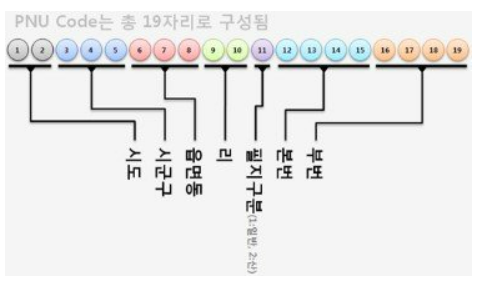

In [ ]:
# 텍스트 파일 n개가 포함된 C(로컬디스크) 내 파일경로 설정
file_path = "/content/drive/MyDrive/2023BigContest/data" + "/" + "수익형부동산_토지이용특성"
# 파일경로 내 텍스트 파일명을 디렉토리 리스트에 저장
field_directory = os.listdir(file_path)
field_dataname: List = [
    ((field_directory[index].split(".csv"))[0]).split("_csv")[0]
    for index in range(len(field_directory))]
display(field_directory)

['ES1007AG00101QY2301_csv.csv',
 'ES1007AG00101QY2204_csv.csv',
 'ES1007AG00101QY2203_csv.csv',
 'ES1007AG00101QY2202_csv.csv',
 'ES1007AG00101QY2201_csv.csv',
 'ES1001AE00101MM2303_csv.csv',
 'ES1001AE00101MM2302_csv.csv',
 'ES1001AE00101MM2301_csv.csv',
 'ES1001AE00101MM2211_csv.csv',
 'ES1001AE00101MM2210_csv.csv',
 'ES1001AE00101MM2212_csv.csv',
 'ES1007AH00101QY2202_csv.csv',
 'ES1007AH00101QY2201_csv.csv',
 'ES1007AH00101QY2203_csv.csv',
 'ES1007AH00101QY2204_csv.csv',
 'ES1007AH00101QY2301_csv.csv']

In [ ]:
# 오아시스비즈니스의 수익형 부동산거래량(금액) 대비 유동인구
# 20231Q, 20224Q, 20223Q, 20222Q, 20221Q

FLOW_DATA_LIST = []

for index, data in zip( list(range(len(field_directory[11:16]))), field_directory[11:16]):
  field_data = mountInstance.loadTxTData(
    file_path = "/content/drive/MyDrive/2023BigContest/data/수익형부동산_토지이용특성/",
    file_name_extension = data,
    unicode = "utf-8", columnTF = False)
  field_data.columns = ["기준연월", "필지고유번호", "법정동코드", "업종코드", "유동인구수"]
  # ["data_strd_ym", "pnu", "legaldong_cd", "induty_cd", "snp_price_scor"]
  # field_data["기준연월"] = field_data["기준연월"].astype("str")
  FLOW_DATA_LIST.append(field_data)
  field_data = 0
# for index in range(0, 5, 1): display(FIELD_DATA_LIST[index].info())

In [ ]:
# 오아시스비즈니스의 수익형 부동산 공실률 대비 매매가, 임대료 데이터
# 20231Q, 20224Q, 20223Q, 20222Q, 20221Q

SNPPRICE_DATA_LIST = []

for index, data in zip( list(range(len(field_directory[0:5]))), field_directory[0:5]):
  field_data = mountInstance.loadTxTData(
    file_path = "/content/drive/MyDrive/2023BigContest/data/수익형부동산_토지이용특성/",
    file_name_extension = data,
    unicode = "utf-8", columnTF = False)
  field_data.columns = ["기준연월", "필지고유번호", "법정동코드", "업종코드", "매매가점수"]
  # ["data_strd_ym", "pnu", "legaldong_cd", "induty_cd", "snp_price_scor"]
  # field_data["기준연월"] = field_data["기준연월"].astype("str")
  SNPPRICE_DATA_LIST.append(field_data)
  field_data = 0
# for index in range(0, 5, 1): display(FIELD_DATA_LIST[index].info())

In [ ]:
pd.set_option("display.max_row", 6)

In [ ]:
SNPPRICE_DATA_LIST[4]

,기준연월,필지고유번호,법정동코드,업종코드,매매가점수
0,202203,1111010100100040014,11110101,B01,58.6100
1,202203,1111010100100480000,11110101,A01,73.9100
2,202203,1111010100100500031,11110101,C05,65.6400
...,...,...,...,...,...
781778,202203,5013032026104230003,50130320,A01,99.2100
781779,202203,5013032026104300003,50130320,C01,99.0900
781780,202203,5013032026104390007,50130320,A03,99.2600


In [ ]:
FLOW_DATA_LIST[4]

,기준연월,필지고유번호,법정동코드,업종코드,유동인구수
0,202303,1111010100100010000,11110101,C05,41.3400
1,202303,1111010100100030100,11110101,A03,23.3500
2,202303,1111010100100040014,11110101,B01,6.8200
...,...,...,...,...,...
1168435,202303,5013032026113660001,50130320,C06,3.2300
1168436,202303,5013032026113660001,50130320,A01,3.9000
1168437,202303,5013032026114300001,50130320,C01,4.0200


In [ ]:
# SNPPRICE_DATA_COPY = SNPPRICE_DATA_LIST*3
# SNPPRICE_DATA = [element for element in SNPPRICE_DATA_COPY]

In [ ]:
import copy
SNPPRICE_DATA1 = copy.deepcopy(SNPPRICE_DATA_LIST)
SNPPRICE_DATA2 = copy.deepcopy(SNPPRICE_DATA_LIST)
SNPPRICE_DATA3 = copy.deepcopy(SNPPRICE_DATA_LIST)

In [ ]:
"""
SNPPRICE_DATA_LIST[5]["기준연월"] = SNPPRICE_DATA_LIST[5]["기준연월"].map({"202303":"202302"},na_action = None)
SNPPRICE_DATA_LIST[6]["기준연월"] = SNPPRICE_DATA_LIST[6]["기준연월"].map({"202212":"202211"},na_action = None)
SNPPRICE_DATA_LIST[7]["기준연월"] = SNPPRICE_DATA_LIST[7]["기준연월"].map({"202209":"202208"},na_action = None)
SNPPRICE_DATA_LIST[8]["기준연월"] = SNPPRICE_DATA_LIST[8]["기준연월"].map({"202206":"202205"},na_action = None)
SNPPRICE_DATA_LIST[9]["기준연월"] = SNPPRICE_DATA_LIST[9]["기준연월"].map({"202203":"202202"},na_action = None)
SNPPRICE_DATA_LIST[10]["기준연월"] = SNPPRICE_DATA_LIST[10]["기준연월"].map({"202303":"202301"},na_action = None)
SNPPRICE_DATA_LIST[11]["기준연월"] = SNPPRICE_DATA_LIST[11]["기준연월"].map({"202212":"202210"},na_action = None)
SNPPRICE_DATA_LIST[12]["기준연월"] = SNPPRICE_DATA_LIST[12]["기준연월"].map({"202209":"202207"},na_action = None)
SNPPRICE_DATA_LIST[13]["기준연월"] = SNPPRICE_DATA_LIST[13]["기준연월"].map({"202206":"202205"},na_action = None)
SNPPRICE_DATA_LIST[14]["기준연월"] = SNPPRICE_DATA_LIST[14]["기준연월"].map({"202203":"202201"},na_action = None)
"""

"""
SNPPRICE_DATA_LIST[5]["기준연월"] = SNPPRICE_DATA_LIST[5]["기준연월"].replace("202303","202302")
SNPPRICE_DATA_LIST[6]["기준연월"] = SNPPRICE_DATA_LIST[6]["기준연월"].replace("202212","202211")
SNPPRICE_DATA_LIST[7]["기준연월"] = SNPPRICE_DATA_LIST[7]["기준연월"].replace("202209","202208")
SNPPRICE_DATA_LIST[8]["기준연월"] = SNPPRICE_DATA_LIST[8]["기준연월"].replace("202206","202205")
SNPPRICE_DATA_LIST[9]["기준연월"] = SNPPRICE_DATA_LIST[9]["기준연월"].replace("202203","202202")

SNPPRICE_DATA_LIST[10]["기준연월"] = SNPPRICE_DATA_LIST[10]["기준연월"].replace("202303","202301")
SNPPRICE_DATA_LIST[11]["기준연월"] = SNPPRICE_DATA_LIST[11]["기준연월"].replace("202212","202210")
SNPPRICE_DATA_LIST[12]["기준연월"] = SNPPRICE_DATA_LIST[12]["기준연월"].replace("202209","202207")
SNPPRICE_DATA_LIST[13]["기준연월"] = SNPPRICE_DATA_LIST[13]["기준연월"].replace("202206","202205")
SNPPRICE_DATA_LIST[14]["기준연월"] = SNPPRICE_DATA_LIST[14]["기준연월"].replace("202203","202201")
"""
for index in range(0, 5, 1):
  SNPPRICE_DATA2[index]["기준연월"] = SNPPRICE_DATA2[index]["기준연월"].apply(
      lambda data: data-1)
for index in range(0, 5, 1):
  SNPPRICE_DATA3[index]["기준연월"] = SNPPRICE_DATA3[index]["기준연월"].apply(
      lambda data: data-2)

In [ ]:
# SNPPRICE_DATA[5]["기준연월"] = SNPPRICE_DATA[5]["기준연월"].apply(lambda data: data-1)

In [ ]:
for index in range(0, 5, 1):
  print(SNPPRICE_DATA1[index]["기준연월"].unique())

[202303]
[202212]
[202209]
[202206]
[202203]


In [ ]:
for index in range(0, 5, 1):
  print(SNPPRICE_DATA2[index]["기준연월"].unique())

[202302]
[202211]
[202208]
[202205]
[202202]


In [ ]:
for index in range(0, 5, 1):
  print(SNPPRICE_DATA3[index]["기준연월"].unique())

[202301]
[202210]
[202207]
[202204]
[202201]


In [ ]:
SNPPRICE_DATA1 = pd.concat(SNPPRICE_DATA1)
SNPPRICE_DATA2 = pd.concat(SNPPRICE_DATA2)
SNPPRICE_DATA3 = pd.concat(SNPPRICE_DATA3)

In [ ]:
SNPPRICE_DATA_MERGE = pd.concat([SNPPRICE_DATA1, SNPPRICE_DATA2, SNPPRICE_DATA3])

In [ ]:
SNPPRICE_DATA_MERGE.reset_index(drop = True, inplace = True)

In [ ]:
SNPPRICE_DATA_MERGE

,기준연월,필지고유번호,법정동코드,업종코드,매매가점수
0,202303,1111010100100040014,11110101,B01,61.7400
1,202303,1111010100100480000,11110101,A01,68.0600
2,202303,1111010100100500031,11110101,C05,67.6600
3,202303,1111010100100530024,11110101,B01,67.2300
4,202303,1111010100100570056,11110101,C05,65.7800
...,...,...,...,...,...
11937430,202201,5013032026100690001,50130320,C06,99.0300
11937431,202201,5013032026101680000,50130320,A01,99.2400
11937432,202201,5013032026104230003,50130320,A01,99.2100
11937433,202201,5013032026104300003,50130320,C01,99.0900


In [ ]:
"""
for datetime, index in zip([202303, 202212, 202209, 202206, 202203], list(range(len(SNPPRICE_DATA_LIST)))):

  # length = len(SNPPRICE_DATA_LIST[index])
  # SNPPRICE_DATA_LIST[index].iloc[0:length, 0] = datetime
  # SNPPRICE_DATA_LIST[index].iloc[length:2*length, 0] = datetime-1
  # InvalidIndexError: You can only assign a scalar value not a <class 'int'>
  # InvalidIndexError: You can only assign a scalar value not a <class 'list'>
  # SNPPRICE_DATA_LIST[index].iloc[2*length:3*length, 0] = datetime-2

  DATETIME_LIST = [datetime, datetime-1, datetime-2]
  print(DATETIME_LIST)
  SNPPRICE_DATA_LIST[index]["기준연월"].astype("int")
  snpprice_1 = SNPPRICE_DATA_LIST[index]
  # snpprice_1["기준일자"] = DATETIME_LIST[0]
  # snpprice_1["기준연월"] = snpprice_1["기준연월"].replace(DATETIME_LIST[0], DATETIME_LIST[0])
  snpprice_2 = SNPPRICE_DATA_LIST[index]
  # snpprice_2["기준연월"] = snpprice_2["기준연월"].replace(DATETIME_LIST[0], DATETIME_LIST[1])
  # snpprice_2["기준일자"] = DATETIME_LIST[1]
  snpprice_3 = SNPPRICE_DATA_LIST[index]
  # snpprice_3["기준연월"] = snpprice_3["기준연월"].replace(DATETIME_LIST[0], DATETIME_LIST[2])
  # snpprice_3["기준일자"] = DATETIME_LIST[2]

  SNPPRICE_DATA_LIST[index] = pd.concat([snpprice_1, snpprice_2, snpprice_3], axis = 0)
  SNPPRICE_DATA_LIST[index].reset_index(drop = True, inplace = True)
"""

[202303, 202302, 202301]
[202212, 202211, 202210]
[202209, 202208, 202207]
[202206, 202205, 202204]
[202203, 202202, 202201]


```
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def RMSPE(y, yhat):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe
```

In [ ]:
# 한국부동산원의 필지고유번호별 신축건축물 정보 데이터(용도지역, 신축구분명, 연면적, 대지면적, 건축면적, 건물주용도명 등)
# 202303, 202302, 202301, 202210, 202211, 202212

FIELD_DATA_LIST = []

for index, data, datetime in zip( list(range(len(field_directory[5:]))), field_directory[5:], [202303, 202302, 202301, 202210, 202211, 202212]):
  field_data = mountInstance.loadTxTData(
    file_path = "/content/drive/MyDrive/2023BigContest/data/수익형부동산_토지이용특성/",
    file_name_extension = data,
    unicode = "utf-8", columnTF = False)
  field_data.columns = ['건축물대장고유번호', '필지고유번호', '지번주소', '신축건축물정보도로명주소코드', '도로명', '지목명', '용도지역명',
                        '용도지구명', '용도구역명', '신축구분명', '주부속건물구분코드', '건물명', '동명', '대지면적', '건축면적',
                        '이전건물면적', '연면적', '이전연면적', '건물주용도명', '이전건물주용도명', '건물구조명', '이전건물구조명',
                        '폐쇄말소일자', '건축허가일자', '건축착공일자', '사용승인일자', '폐쇄말소구분명', '폐쇄말소주건물수', '폐쇄말소부속건물수']
  field_data = field_data[["필지고유번호", "용도지역명", "신축구분명", '신축건축물정보도로명주소코드',
                           "주부속건물구분코드", '건물주용도명', "건물구조명", "대지면적", "건축면적", "연면적"]]
  field_data["기준일자"] = datetime
  FIELD_DATA_LIST.append(field_data)
  field_data = 0
  # ParserError: Error tokenizing data. C error: Expected 1 fields in line 718, saw 2
# for index in range(0, 5, 1): display(FIELD_DATA_LIST[index].info())


In [ ]:
display(FIELD_DATA_LIST[1].head(3))
display(FIELD_DATA_LIST[2].head(3))
display(FIELD_DATA_LIST[5].head(3))

In [ ]:
FIELD_DATA_LIST.pop(0)
FIELD_DATA_LIST.pop(2)
FIELD_DATA_LIST.pop(2)

In [ ]:
display(FIELD_DATA_LIST[0].head(3))
display(FIELD_DATA_LIST[1].head(3))
display(FIELD_DATA_LIST[2].head(3))

,필지고유번호,용도지역명,신축구분명,신축건축물정보도로명주소코드,주부속건물구분코드,건물주용도명,건물구조명,대지면적,건축면적,연면적,기준일자
0,1111015500001570001,도시지역,신축허가,1111030050061550300008900003,주건축물,제2종근린생활시설,철근콘크리트구조,261.4000,152.5500,299.8000,202302
1,1111015500001600001,도시지역,신축허가,1111041003091550200002300000,주건축물,제2종근린생활시설,철근콘크리트구조,522.3000,307.6000,604.4900,202302
2,1111015500001610011,도시지역,신축허가,1111041003091550200003100003,주건축물,제2종근린생활시설,철근콘크리트구조,286.3000,167.5200,325.5000,202302


,필지고유번호,용도지역명,신축구분명,신축건축물정보도로명주소코드,주부속건물구분코드,건물주용도명,건물구조명,대지면적,건축면적,연면적,기준일자
0,1111011100000470394,제1종일반주거지역,신축허가,1111041005221110200001100000,주건축물,제2종근린생활시설,철근콘크리트구조,139.2000,81.1800,256.8100,202301
1,1111015900000980000,NaN,신축허가,1111041004101590100002200004,주건축물,제2종근린생활시설,철근콘크리트구조,121.7000,61.4400,164.0100,202301
2,1111016000001790000,일반상업지역,신축허가,1111041003211600200005000007,주건축물,숙박시설,철근콘크리트구조,114.9000,68.8000,453.9100,202301


,필지고유번호,용도지역명,신축구분명,신축건축물정보도로명주소코드,주부속건물구분코드,건물주용도명,건물구조명,대지면적,건축면적,연면적,기준일자
0,1111010800001370012,NaN,신축허가,1111041003041080100000300002,주건축물,단독주택,철근콘크리트구조,113.0200,56.4000,162.7400,202212
1,1111011000001070003,NaN,신축신고,1111041005271100200001300001,주건축물,단독주택,일반목구조,43.0000,18.6400,18.6400,202212
2,1111014100000560000,제1종일반주거지역,신축허가,1111041002151410100003800000,주건축물,제1종근린생활시설,철근콘크리트구조,94.3000,48.9900,143.8000,202212


In [ ]:
for column in ["용도지역명", "신축구분명", "주부속건물구분코드", '건물주용도명', "건물구조명"
               # "대지면적", "건축면적", "대지면적", "건축면적", "연면적", '이전건물면적', '연면적'
               ]:
  print(Counter(FIELD_DATA_LIST[0][column]))

Counter({nan: 1313, '계획관리지역': 1295, '자연녹지지역': 406, '제2종일반주거지역': 373, '제1종일반주거지역': 363, '보전관리지역': 322, '도시지역': 297, '생산관리지역': 296, '농림지역': 289, '가축사육제한구역': 147, '생산녹지지역': 76, '일반공업지역': 71, '일반상업지역': 60, '준주거지역': 58, '제1종전용주거지역': 42, '준공업지역': 34, '자연환경보전지역': 34, '제3종일반주거지역': 30, '보전녹지지역': 21, '가로구역별최고높이제한지역': 7, '근린상업지역': 7, '중심상업지역': 5, '전용공업지역': 4, '제2종전용주거지역': 3, '일반주거지역': 3, '농업진흥구역': 3, '준보전산지': 2, '상대보호구역': 1, '개발제한구역': 1, '상업지역': 1, '유통상업지역': 1, '산업단지기타': 1, '택지개발예정지구': 1, '도시계획용도지역미지정': 1, '공장설립승인지역': 1, '역사문화환경보존지역': 1})
Counter({'신축신고': 2903, '신축허가': 2667})
Counter({'주건축물': 5160, '부속건축물': 410})
Counter({'단독주택': 2388, '제2종근린생활시설': 1049, '제1종근린생활시설': 551, '공장': 350, '창고시설': 334, '동.식물관련시설': 300, '공동주택': 290, '업무시설': 58, '숙박시설': 48, '자동차관련시설': 40, '교정및군사시설': 25, '야영장시설': 22, '위험물저장및처리시설': 21, '노유자시설': 18, '교육연구시설': 16, '운동시설': 16, '종교시설': 14, '자원순환관련시설': 12, '의료시설': 7, '판매시설': 5, '관광휴게시설': 2, '문화및집회시설': 2, '방송통신시설': 1, '발전시설': 1})
Counter({'철근콘크리트구조': 1922, '경량철골구조': 1424, '일반철골구조

___

In [ ]:
CONTEST_2022.columns = ["기준연월", "필지고유번호", "법정동코드", "업종코드", "매출등급"]
CONTEST_2023.columns = ["필지고유번호", "업종코드", "법정동코드", "2023년1월_예측매출등급", "2023년2월_예측매출등급"]

In [ ]:
CONTEST_2022["기준연월"] = CONTEST_2022["기준연월"].astype("int")

In [ ]:
CONTEST_2022_SNPPRICE = pd.merge(
    left = CONTEST_2022, right = SNPPRICE_DATA_MERGE,
    on = ["기준연월", "필지고유번호", "법정동코드", "업종코드"],
    how = "left"
)
# ValueError: You are trying to merge on int64 and object columns. If you wish to proceed you should use pd.concat

In [ ]:
CONTEST_2023_SNPPRICE = pd.merge(
    left = CONTEST_2023, right = SNPPRICE_DATA_MERGE[SNPPRICE_DATA_MERGE["기준연월"] == 202301],
    on = ["필지고유번호", "법정동코드", "업종코드"],
    how = "left"
)

In [ ]:
# SNPPRICE_DATA_MERGE.to_csv("/content/drive/MyDrive/2023BigContest/data/SNPPRICE_DATA_MERGE.csv", index = False)

In [ ]:
CONTEST_2023_FIELD = pd.merge(
    left = CONTEST_2023, right = FIELD_DATA_LIST[0],
    on = ["필지고유번호"],
    how = "left"
)
CONTEST_2023_FIELD.isnull().sum()

필지고유번호                0
업종코드                  0
법정동코드                 0
2023년1월_예측매출등급    10000
2023년2월_예측매출등급    10000
용도지역명             10000
신축구분명             10000
신축건축물정보도로명주소코드    10000
주부속건물구분코드         10000
건물주용도명            10000
건물구조명             10000
대지면적              10000
건축면적              10000
연면적               10000
기준일자              10000
dtype: int64

### 12.오아시스비즈니스 플랫폼의 매출등급 인덱스인 필지고유번호에 해당하는 (상권별 업종별 소호 사업장의 매출등급을 예측하기 위한) 매매가점수를 활용한 로지스틱 추정확률 생성

* DataFrame 값에 선형으로 비례하는 방식으로 결측값 보간
(interpolate DataFrame missing values linearly)

In [ ]:
CONTEST_2022_FEATURE = pd.read_csv("/content/drive/MyDrive/2023BigContest/data/CONTEST_2022_FEATURE.csv", index_col = False)
CONTEST_2023_FEATURE = pd.read_csv("/content/drive/MyDrive/2023BigContest/data/CONTEST_2023_FEATURE.csv", index_col = False)

In [ ]:
# CONTEST_2023_FEATURE.to_csv("/content/drive/MyDrive/2023BigContest/data/CONTEST_2023_FEATURE.csv", index = False)

In [ ]:
SEASON_PATTERN = pd.read_csv("/content/drive/MyDrive/2023BigContest/data/KCD_SEASON_PATTERN.csv", index_col = False)

```
CONTEST_2022_FLOW = pd.read_csv("/content/drive/MyDrive/2023BigContest/data/CONTEST_2022_FLOW.csv", index_col = False)
CONTEST_2023_FLOW = pd.read_csv("/content/drive/MyDrive/2023BigContest/data/CONTEST_2023_FLOW.csv", index_col = False)

CONTEST_2022_SNPPRICE = pd.read_csv("/content/drive/MyDrive/2023BigContest/data/CONTEST_2022_SNPPRICE.csv", index_col = False)
CONTEST_2023_SNPPRICE = pd.read_csv("/content/drive/MyDrive/2023BigContest/data/CONTEST_2023_SNPPRICE.csv", index_col = False)
SEASON_PATTERN = pd.read_csv("/content/drive/MyDrive/2023BigContest/data/KCD_SEASON_PATTERN.csv", index_col = False)

CONTEST_2022_FEATURE = pd.merge(
    left = CONTEST_2022_SNPPRICE, right = CONTEST_2022_FLOW,
    on = ["기준연월", "필지고유번호", "법정동코드", "업종코드", "매출등급"],
    how = "outer"
)
# CONTEST_2022_FEATURE.to_csv("/content/drive/MyDrive/2023BigContest/data/CONTEST_2022_FEATURE.csv", index = False)

# KNN Imputer 모델 초기화
knnimputer = KNNImputer(n_neighbors = 5)
CONTEST_2023_SNPPRICE["1월_매매가점수"] = 0.35509817*CONTEST_2023_SNPPRICE["매매가점수"]
CONTEST_2023_SNPPRICE["2월_매매가점수"] = 0.18389077*CONTEST_2023_SNPPRICE["매매가점수"]

# 대체된 데이터를 데이터프레임으로 변환
CONTEST_2023_SNPPRICE.drop("기준연월", axis = 1, inplace = True)
CONTEST_2023_SNPPRICE["1월_매매가점수"] = knnimputer.fit_transform(CONTEST_2023_SNPPRICE[["1월_매매가점수"]])
CONTEST_2023_SNPPRICE["2월_매매가점수"] = knnimputer.fit_transform(CONTEST_2023_SNPPRICE[["2월_매매가점수"]])
# CONTEST_2023_SNPPRICE.to_csv("/content/drive/MyDrive/2023BigContest/data/CONTEST_2023_SNPPRICE.csv", index = False)
# CONTEST_2022_SNPPRICE["매매가점수"] = knnimputer.fit_transform(CONTEST_2022_SNPPRICE[["매매가점수"]])

CONTEST_2023_FEATURE = pd.merge(
    left = CONTEST_2023_SNPPRICE, right = CONTEST_2023_FLOW,
    on = ["필지고유번호", "업종코드", "법정동코드", "2023년1월_예측매출등급", "2023년2월_예측매출등급"],
    how = "outer"
)
# CONTEST_2023_FEATURE.to_csv("/content/drive/MyDrive/2023BigContest/data/CONTEST_2023_FEATURE.csv", index = False)
```

```
pca = PCA(n_components=1)  
# 주성분을 1개로 설정
SEASONAL_PCA = abs(pca.fit_transform(SEASON_PATTERN.drop("기준일자", axis = 1)))

print(SEASON_PATTERN["기준일자"], SEASONAL_PCA)
# 어차피 방향성이 중요하기 때문에 절댓값 씌움

CONTEST_2023_SNPPRICE["1월_매매가점수"] = 0.35509817*CONTEST_2023_SNPPRICE["매매가점수"]
CONTEST_2023_SNPPRICE["2월_매매가점수"] = 0.18389077*CONTEST_2023_SNPPRICE["매매가점수"]

CONTEST_2023_FLOW["1월_부동산거래량/금액대비_유동인구"] = 0.35509817*CONTEST_2023_FLOW["부동산거래량/금액대비_유동인구"]
CONTEST_2023_FLOW["2월_부동산거래량/금액대비_유동인구"] = 0.18389077*CONTEST_2023_FLOW["부동산거래량/금액대비_유동인구"]
```

```
IMPUTED_DATA = CONTEST_2022_FEATURE[["매매가점수", "부동산거래량/금액대비_유동인구"]]
IMPUTED_FEATURE = IMPUTED_DATA.interpolate(method = "polynomial", order = 2)
IMPUTED_FEATURE.columns = ["회귀대체_매매가점수", "회귀대체_유동인구수"]
CONTEST_2022_FEATURE[["회귀대체_매매가점수", "회귀대체_유동인구수"]] = IMPUTED_FEATURE

# IMPUTED_FEATURE = fast_knn(CONTEST_2022_FEATURE[["매매가점수", "부동산거래량/금액대비_유동인구"]], k=5)
# AttributeError: 'DataFrame' object has no attribute 'as_matrix' : CONTEST_2022_FEATURE[["매매가점수", "부동산거래량/금액대비_유동인구"]]
# BadInputError: No support for arrays that aren't 2D yet.
```

In [ ]:
# 결측값 1개는 평균값으로 대체
# CONTEST_2022_FEATURE["회귀대체_매매가점수"] = CONTEST_2022_FEATURE["회귀대체_매매가점수"].fillna(CONTEST_2022_FEATURE["회귀대체_매매가점수"].mean())

In [ ]:
CONTEST_2022_FEATURE["매출등급"].unique()

array([4, 2, 3, 1, 5])

In [ ]:
CONTEST_2022_FEATURE

,기준연월,필지고유번호,법정동코드,업종코드,매출등급,매매가점수,부동산거래량/금액대비_유동인구,회귀대체_매매가점수,회귀대체_유동인구수,매출등급_로짓추정확률,매출등급_로짓추정확률_주성분
0,202201,1111010100100030100,11110101,A03,4,NaN,19.7600,67.9510,19.7600,[0.11847218 0.24361776 0.29205528 0.2470159 0...,[2.04571238]
1,202201,1111010100100480000,11110101,A01,2,73.9100,39.1300,73.9100,39.1300,[0.10636295 0.24832366 0.29734681 0.24860052 0...,[0.6964639]
2,202201,1111010100100590001,11110101,A11,3,64.2500,27.2600,64.2500,27.2600,[0.11283576 0.24517467 0.29440009 0.24825978 0...,[1.41105612]
3,202201,1111010100100590005,11110101,A03,2,71.8000,21.0300,71.8000,21.0300,[0.11812751 0.24410063 0.2922612 0.24678916 0...,[2.01105691]
4,202201,1111010100100690000,11110101,A01,2,79.3800,23.9300,79.3800,23.9300,[0.11717468 0.24514633 0.29278233 0.2463891 0...,[1.9121711]
...,...,...,...,...,...,...,...,...,...,...,...
1161312,202212,1174011000106950000,11740110,A03,4,NaN,60.0700,74.5995,60.0700,[0.09384824 0.25277596 0.30289646 0.25045508 0...,[0.70385448]
1161313,202212,1174011000106950000,11740110,A04,3,NaN,50.8500,74.3252,50.8500,[0.09919111 0.25086192 0.3005044 0.24968827 0...,[0.10595481]
1161314,202212,1174011000106990000,11740110,A01,4,NaN,26.6100,73.6205,26.6100,[0.11454521 0.24548957 0.293814 0.247269 0...,[1.61199287]
1161315,202212,1174011000107070000,11740110,A03,4,NaN,41.3200,72.4855,41.3200,[0.10479925 0.24872725 0.29800704 0.24895769 0...,[0.51994343]


In [ ]:
# 예측에 사용할 열 선택
X = CONTEST_2022_FEATURE[['회귀대체_매매가점수', '회귀대체_유동인구수']]
  # ValueError: Input X contains NaN.
y = CONTEST_2022_FEATURE["매출등급"]

# 로지스틱 회귀 모델 생성 및 학습
glm = LogisticRegression()
# glm = LogisticRegression(C = 20, max_iter = 1000)

glm.fit(X, y)
# 테스트 데이터로 예측 확률 생성
probability = glm.predict_proba(X)
  # probability는 배열 형태로, 각 행은 각 샘플에 대한 각 클래스(매출등급)의 예측 확률
  # 예를 들어, probability[0]은 첫 번째 테스트 샘플에 대한 매출등급 예측 확률

In [ ]:
probability
# CONTEST_2022_FEATURE["매출등급_로짓추정확률"] = list(probability)

array([[0.11847218, 0.24361776, 0.29205528, 0.2470159 , 0.09883888],
       [0.10636295, 0.24832366, 0.29734681, 0.24860052, 0.09936606],
       [0.11283576, 0.24517467, 0.29440009, 0.24825978, 0.09932969],
       ...,
       [0.11454521, 0.24548957, 0.293814  , 0.247269  , 0.09888222],
       [0.10479925, 0.24872725, 0.29800704, 0.24895769, 0.09950877],
       [0.10859339, 0.24726633, 0.29633219, 0.24846411, 0.09934397]])

In [ ]:
pca = PCA(n_components=1)
# 주성분을 1개로 설정

# probability
PROB_PCA = abs(pca.fit_transform(probability*100))
# CONTEST_2022_FEATURE["매출등급_로짓추정확률_주성분"] = list(PROB_PCA)

In [ ]:
CONTEST_2022_FEATURE["매출등급_로짓추정확률_주성분"] = CONTEST_2022_FEATURE["매출등급_로짓추정확률_주성분"].apply(lambda x: str(x).replace("[", ""))
CONTEST_2022_FEATURE["매출등급_로짓추정확률_주성분"] = CONTEST_2022_FEATURE["매출등급_로짓추정확률_주성분"].apply(lambda x: str(x).replace("]", ""))
CONTEST_2022_FEATURE["매출등급_로짓추정확률_주성분"] = CONTEST_2022_FEATURE["매출등급_로짓추정확률_주성분"].astype("float")

In [ ]:
CONTEST_2022_Y_LABEL = CONTEST_2022_FEATURE.groupby(["법정동코드", "업종코드", "매출등급", "매출등급_로짓추정확률_주성분"]).count()
CONTEST_2022_Y_LABEL.reset_index(inplace = True)
CONTEST_2022_Y_LABEL = CONTEST_2022_Y_LABEL.iloc[:, 0:5]
CONTEST_2022_Y_LABEL["매출등급x로짓추정확률"] = CONTEST_2022_Y_LABEL["매출등급"] * CONTEST_2022_Y_LABEL["매출등급_로짓추정확률_주성분"]/100
CONTEST_2022_YLABEL = pd.DataFrame(CONTEST_2022_Y_LABEL.groupby(["법정동코드", "업종코드"])["매출등급x로짓추정확률"].agg(sum))
CONTEST_2022_YLABEL.reset_index(inplace = True)

In [ ]:
def PREDICTED_GRADE(data):
  if data <= 1: return 1
  elif data <= 2: return 2
  elif data <= 3: return 3
  elif data <= 4: return 4
  else: # data >= 5:
    return 5

In [ ]:
CONTEST_2022_YLABEL["매출등급x로짓추정확률"] = CONTEST_2022_YLABEL["매출등급x로짓추정확률"].apply(PREDICTED_GRADE)

In [ ]:
CONTEST_2022_YLABEL

,법정동코드,업종코드,매출등급x로짓추정확률
0,11110101,A01,2
1,11110101,A03,3
2,11110101,A08,1
3,11110101,A11,1
4,11110101,A14,2
...,...,...,...
4882,11740110,A08,2
4883,11740110,A09,1
4884,11740110,A10,1
4885,11740110,A11,1


In [ ]:
# CONTEST_2022_YLABEL.to_csv("/content/drive/MyDrive/2023BigContest/data/CONTEST_2022_Y_LABEL.csv", index = False)

In [ ]:
CONTEST_2023_FEATURE

,필지고유번호,업종코드,법정동코드,2023년1월_예측매출등급,2023년2월_예측매출등급,매매가점수,1월_매매가점수,2월_매매가점수,부동산거래량/금액대비_유동인구,1월_부동산거래량/금액대비_유동인구,2월_부동산거래량/금액대비_유동인구,1월_매출등급_로짓추정확률_주성분,2월_매출등급_로짓추정확률_주성분
0,1168010800102090000,A01,11680108,NaN,NaN,NaN,24.7989,12.8424,45.0600,16.0007,8.2861,0.0014,0.0007
1,1135010300106330015,A05,11350103,NaN,NaN,NaN,24.7989,12.8424,NaN,17.7894,9.2124,0.0000,0.0000
2,1154510200109830004,A02,11545102,NaN,NaN,74.0900,26.3092,13.6245,41.5300,14.7472,7.6370,0.0026,0.0014
3,1162010200100920362,A01,11620102,NaN,NaN,76.4300,27.1402,14.0548,61.0000,21.6610,11.2173,0.0027,0.0014
4,1168011000104580000,A03,11680110,NaN,NaN,NaN,24.7989,12.8424,NaN,17.7894,9.2124,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10039,1130510100100830004,A03,11305101,NaN,NaN,66.3800,23.5714,12.2067,52.9800,18.8131,9.7425,0.0010,0.0005
10040,1135010300107450000,A13,11350103,NaN,NaN,NaN,24.7989,12.8424,36.4100,12.9291,6.6955,0.0038,0.0020
10041,1150010300103400017,A06,11500103,NaN,NaN,70.0700,24.8817,12.8852,45.9800,16.3274,8.4553,0.0011,0.0006
10042,1144012700116070000,A03,11440127,NaN,NaN,78.2600,27.7900,14.3913,56.9700,20.2299,10.4763,0.0015,0.0008


In [ ]:
X_202301 = CONTEST_2023_FEATURE[["1월_매매가점수", "1월_부동산거래량/금액대비_유동인구"]]
X_202302 = CONTEST_2023_FEATURE[["2월_매매가점수", "2월_부동산거래량/금액대비_유동인구"]]
X_202301.columns = ["회귀대체_매매가점수", "회귀대체_유동인구수"]
X_202302.columns = ["회귀대체_매매가점수", "회귀대체_유동인구수"]

In [ ]:
PREDICTED_PROBA_X_202301 = abs(pca.fit_transform(glm.predict_proba(X_202301)))
PREDICTED_PROBA_X_202302 = abs(pca.fit_transform(glm.predict_proba(X_202302)))

In [ ]:
CONTEST_2023_FEATURE["1월_매출등급_로짓추정확률_주성분"] = PREDICTED_PROBA_X_202301
CONTEST_2023_FEATURE["2월_매출등급_로짓추정확률_주성분"] = PREDICTED_PROBA_X_202302

CONTEST_2023_FEATURE["1월_매출등급_로짓추정확률_주성분"] = CONTEST_2023_FEATURE["1월_매출등급_로짓추정확률_주성분"].apply(lambda x: str(x).replace("[", ""))
CONTEST_2023_FEATURE["1월_매출등급_로짓추정확률_주성분"] = CONTEST_2023_FEATURE["1월_매출등급_로짓추정확률_주성분"].apply(lambda x: str(x).replace("]", ""))
CONTEST_2023_FEATURE["1월_매출등급_로짓추정확률_주성분"] = CONTEST_2023_FEATURE["1월_매출등급_로짓추정확률_주성분"].astype("float")

CONTEST_2023_FEATURE["2월_매출등급_로짓추정확률_주성분"] = CONTEST_2023_FEATURE["2월_매출등급_로짓추정확률_주성분"].apply(lambda x: str(x).replace("[", ""))
CONTEST_2023_FEATURE["2월_매출등급_로짓추정확률_주성분"] = CONTEST_2023_FEATURE["2월_매출등급_로짓추정확률_주성분"].apply(lambda x: str(x).replace("]", ""))
CONTEST_2023_FEATURE["2월_매출등급_로짓추정확률_주성분"] = CONTEST_2023_FEATURE["2월_매출등급_로짓추정확률_주성분"].astype("float")

---

### 13.태블로를 이용한 데이터 시각화용 데이터프레임

In [ ]:
KCD_DATA = pd.read_csv("/content/drive/MyDrive/2023BigContest/data/DESILO_PLATFORM_DATA/KCD_DATA.csv", index_col = False, encoding = "euc-kr")

In [ ]:
KCD_DATA = KCD_DATA[KCD_DATA["기준일자"].isin([202201, 202202, 202203, 202204, 202205, 202206, 202207, 202208, 202209, 202210, 202211, 202212])]

In [ ]:
KCD_LOC_MAP = pd.merge(
    left = KCD_DATA, right = MARKET_LOC_MAP[["상권_코드_2022", "STDG_EMD_CD"]],
    left_on = "상권코드", right_on = "상권_코드_2022", how = "left")
KCD_LOC_MAP.drop("상권_코드_2022", axis = 1, inplace = True)

In [ ]:
KCD_LOC_MAP = KCD_LOC_MAP[KCD_LOC_MAP["STDG_EMD_CD"].isna() == False]

In [ ]:
DATETIME_LIST = KCD_DATA["기준일자"].unique()
DATETIME_LIST[0:12]

array([202201, 202202, 202203, 202204, 202205, 202206, 202207, 202208,
       202209, 202210, 202211, 202212])

In [ ]:
CONTEST_2022.rename({"DATA_CRTR_YM":"기준일자"}, axis = 1, inplace = True)

In [ ]:
KCD_CONTEST_MERGE = pd.merge(
    left = KCD_LOC_MAP, right = CONTEST_2022[["기준일자", "STDG_EMD_CD", "SLS_GRD"]],
    on = ["기준일자", "STDG_EMD_CD"], how = "left")

In [ ]:
KCD_CONTEST_MERGE.rename({"STDG_EMD_CD":"법정동코드"}, axis = 1, inplace = True)
KCD_CONTEST_MERGE.rename({"SLS_GRD":"매출등급"}, axis = 1, inplace = True)

In [ ]:
KCD_CONTEST_MERGE.drop_duplicates(inplace = True)

In [ ]:
KCD_CONTEST_MERGE = pd.read_csv("/content/drive/MyDrive/2023BigContest/data/DESILO_PLATFORM_DATA/KCD_CONTEST_MERGE.csv", index_col = False)

In [ ]:
KCD_CONTEST_MERGE = KCD_CONTEST_MERGE[KCD_CONTEST_MERGE["매출등급"].isna() == False]

In [ ]:
KCD_CONTEST_MERGE.isnull().sum()

In [ ]:
# KCD_CONTEST_MERGE.to_csv("/content/drive/MyDrive/2023BigContest/data/DESILO_PLATFORM_DATA/KCD_CONTEST_MERGE.csv", index = False)